In [1]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
import implicitmodules.torch as dm

from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


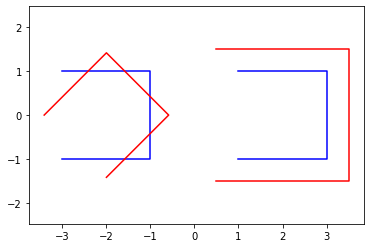

In [3]:
a = 1.

shape0 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) - torch.tensor([2., 0.])
shape0.requires_grad_()
a=1.
shape1 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) + torch.tensor([2., 0.])
shape1.requires_grad_()

a = math.sqrt(2)
target0 = torch.tensor([[0., -a], [a, 0.], [0., a], [-a, 0.]]) -torch.tensor([2., 0.])
target0.requires_grad_()

a=1.5
target1 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) + torch.tensor([2., 0.])
target1.requires_grad_()

scale_scaling = 2.
scaling = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[2., 0.]], requires_grad=True))
scale_rotation = 2.
rotation = dm.DeformationModules.LocalRotation(2, scale_rotation, gd=torch.tensor([[-2., 0.]], requires_grad=True))

boundary0 = dm.MultiShape.Boundary(shape0)
boundary1 = dm.MultiShape.Boundary(shape1)

source_deformable0 = dm.Models.DeformablePoints(shape0)
source_deformable1 = dm.Models.DeformablePoints(shape1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)


plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '-r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '-r')
plt.axis('equal')
plt.show()


attach = dm.Attachment.EuclideanPointwiseDistanceAttachment()

shoot_solver = 'torch_euler'
shoot_it = 10

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])

#constraints = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0, 0], [1, 0], compound_man)
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])
model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[rotation], [scaling]], [attach, attach], 0.1, constraints=constraints)

multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, 0.5)

In [4]:
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, 0.5)
multishape.manifold.fill_gd(model.init_manifold.gd)
multishape.manifold.fill_cotan(model.init_manifold.cotan)
Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)


In [5]:
model.init_manifold.fill_cotan([[torch.tensor([[ 1.2450,  0.3050],
                                              [-0.5410, -1.4626],
                                              [1.0935, -1.0529],
                                              [-0.0733, -0.3925]], requires_grad=True),
 torch.tensor([[ 0.7895, -1.4652]], requires_grad=True),
 torch.tensor([[1.0059, -1.0556],
         [0.3768, -0.0564],
         [-0.8697, -0.9240],
         [-0.5791, -0.3156]], requires_grad=True)],
 [torch.tensor([[ 0.7536,  1.5738],
               [1.9498,  0.8120],
               [-0.8017, -0.9764],
               [0.6127,  0.5695]],
         requires_grad=True),
  torch.tensor([1.1456, 0.7664], requires_grad=True),
  torch.tensor([[ 0.3134,  0.4878],
               [-0.1439, -0.0940],
               [0.1144, -0.5274],
               [0.8335,  1.0186]],
         requires_grad=True)],
 [torch.tensor([[0., 0.],
               [0., 0.],
               [0., 0.],
               [0., 0.]],requires_grad=True),
  torch.tensor([[0., 0.],
               [0., 0.],
               [0., 0.],
               [0., 0.]],requires_grad=True)]])


In [6]:
Ham.modules.manifold.cotan

[[tensor([[ 1.2450,  0.3050],
          [-0.5410, -1.4626],
          [ 1.0935, -1.0529],
          [-0.0733, -0.3925]], requires_grad=True),
  tensor([[ 0.7895, -1.4652]], requires_grad=True),
  tensor([[ 1.0059, -1.0556],
          [ 0.3768, -0.0564],
          [-0.8697, -0.9240],
          [-0.5791, -0.3156]], requires_grad=True)],
 [tensor([[ 0.7536,  1.5738],
          [ 1.9498,  0.8120],
          [-0.8017, -0.9764],
          [ 0.6127,  0.5695]], requires_grad=True),
  tensor([1.1456, 0.7664], requires_grad=True),
  tensor([[ 0.3134,  0.4878],
          [-0.1439, -0.0940],
          [ 0.1144, -0.5274],
          [ 0.8335,  1.0186]], requires_grad=True)],
 [tensor([[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]], requires_grad=True), tensor([[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]], requires_grad=True)]]

In [8]:
gd = torch.tensor([[-3., -1.],
        [-1., -1.],
        [-1.,  1.],
        [-3.,  1.]], requires_grad=True)
#tan = torch.tensor([[-0.0026,  0.0334],[ 0.0295,  0.0312],[ 0.0090,  0.0313],[ 0.0082,  0.0448]])

man = dm.Manifolds.Landmarks(2, 4, gd=gd)

mod = rotation

In [11]:
mod.fill_controls(torch.tensor([[1., 0.],
        [-3., 2.],
        [-1., -1.]]))

mod.field_generator()(man.gd)

StructuredField0
tensor([[-3., -1.],
        [-1., -1.],
        [-1.,  1.],
        [-3.,  1.]], requires_grad=True) tensor([[-1.3333,  0.0000],
        [-2.3333,  0.5774],
        [-2.3333, -0.5774]], grad_fn=<AddBackward0>) 2.0
K_q tensor([[0.6236, 0.6931, 0.9251],
        [0.8703, 0.5867, 0.7831],
        [0.8703, 0.7831, 0.5867],
        [0.6236, 0.9251, 0.6931]], grad_fn=<ExpBackward>)
controls tensor([[-0.0000,  0.0000],
        [ 2.5981, -1.0000],
        [-0.8660,  0.5000]])


tensor([[ 0.9996, -0.2306],
        [ 0.8462, -0.1952],
        [ 1.5263, -0.4897],
        [ 1.8032, -0.5785]], grad_fn=<MmBackward>)

In [13]:
man.fill_cotan(torch.tensor([ 0.2457, -0.9911,  0.0633,  0.3473, -0.1318,  0.1082, -0.0763, -0.2113],
       requires_grad=True))

In [14]:
man.infinitesimal_action(mod.field_generator()).tan

StructuredField0
tensor([[-3., -1.],
        [-1., -1.],
        [-1.,  1.],
        [-3.,  1.]], requires_grad=True) tensor([[-1.3333,  0.0000],
        [-2.3333,  0.5774],
        [-2.3333, -0.5774]], grad_fn=<AddBackward0>) 2.0
K_q tensor([[0.6236, 0.6931, 0.9251],
        [0.8703, 0.5867, 0.7831],
        [0.8703, 0.7831, 0.5867],
        [0.6236, 0.9251, 0.6931]], grad_fn=<ExpBackward>)
controls tensor([[-0.0000,  0.0000],
        [ 2.5981, -1.0000],
        [-0.8660,  0.5000]])


tensor([[ 0.9996, -0.2306],
        [ 0.8462, -0.1952],
        [ 1.5263, -0.4897],
        [ 1.8032, -0.5785]], grad_fn=<MmBackward>)

In [7]:
Ham.module.compute_geodesic_variables(Ham.constraints)

tan0 tensor([[ 0.0608, -0.0562],
        [ 0.0515,  0.0562],
        [-0.0515,  0.0562],
        [-0.0608, -0.0562]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.2946,  0.3191],
        [-0.2946,  0.2701],
        [-0.2946, -0.2701],
        [ 0.2946, -0.3191]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)


In [8]:
torch.set_printoptions(precision=10)
[Ham.module[i].controls for i in range(3)]

[[tensor([], requires_grad=True),
  tensor(0.1893765020, grad_fn=<DivBackward0>),
  tensor([], requires_grad=True)],
 [tensor([], requires_grad=True),
  tensor(-0.9931470090, grad_fn=<DivBackward0>),
  tensor([], requires_grad=True)],
 [tensor([[ 0.0380419820, -0.0351251733],
          [ 0.0322018425,  0.0351184264],
          [-0.0322018425,  0.0351184264],
          [-0.0380419820, -0.0351251733]], grad_fn=<CopyBackwards>),
  tensor([[ 0.1842069131,  0.1995035298],
          [-0.1841715302,  0.1688760920],
          [-0.1841715302, -0.1688760920],
          [ 0.1842069131, -0.1995035298]], grad_fn=<CopyBackwards>)]]

In [15]:
Ham.module[0].controls[1].dtype

torch.float64

In [9]:
man = Ham.modules.manifold.infinitesimal_action(Ham.modules.field_generator())
man.tan

[[tensor([[ 0.0380419820, -0.0351251733],
          [ 0.0322018425,  0.0351184264],
          [-0.0322018425,  0.0351184264],
          [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>),
  tensor([[-4.8269270461e-17, -4.1774611519e-17]], grad_fn=<AddBackward0>),
  tensor([[ 0.0380419820, -0.0351251733],
          [ 0.0322018425,  0.0351184264],
          [-0.0322018425,  0.0351184264],
          [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>)],
 [tensor([[ 0.1842069131,  0.1995035298],
          [-0.1841715302,  0.1688760920],
          [-0.1841715302, -0.1688760920],
          [ 0.1842069131, -0.1995035298]], grad_fn=<AddBackward0>),
  tensor([[ 1.9435316630e-16, -2.7893715573e-16]], grad_fn=<AddBackward0>),
  tensor([[ 0.1842069131,  0.1995035298],
          [-0.1841715302,  0.1688760920],
          [-0.1841715302, -0.1688760920],
          [ 0.1842069131, -0.1995035298]], grad_fn=<AddBackward0>)],
 [tensor([[ 0.0380419820, -0.0351251733],
          [ 0.0322018425,  0

In [10]:
Ham.constraints(man)

tan0 tensor([[ 0.0380419820, -0.0351251733],
        [ 0.0322018425,  0.0351184264],
        [-0.0322018425,  0.0351184264],
        [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>)
tan1 tensor([[ 0.0380419820, -0.0351251733],
        [ 0.0322018425,  0.0351184264],
        [-0.0322018425,  0.0351184264],
        [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.1842069131,  0.1995035298],
        [-0.1841715302,  0.1688760920],
        [-0.1841715302, -0.1688760920],
        [ 0.1842069131, -0.1995035298]], grad_fn=<AddBackward0>)
tan1 tensor([[ 0.1842069131,  0.1995035298],
        [-0.1841715302,  0.1688760920],
        [-0.1841715302, -0.1688760920],
        [ 0.1842069131, -0.1995035298]], grad_fn=<AddBackward0>)


tensor([[-5.5511151231e-17],
        [ 4.8572257327e-17],
        [-6.9388939039e-17],
        [ 0.0000000000e+00],
        [ 2.0816681712e-17],
        [-6.9388939039e-18],
        [ 6.9388939039e-18],
        [ 3.4694469520e-17],
        [-2.7755575616e-17],
        [-5.5511151231e-17],
        [ 1.6653345369e-16],
        [-8.3266726847e-17],
        [ 5.5511151231e-17],
        [-2.7755575616e-17],
        [-5.5511151231e-17],
        [-1.3877787808e-16]], grad_fn=<CatBackward>)

In [11]:
Ham.geodesic_controls()

constraints call
indexes0 [0, 2]
indexes1 [2, 0]
tan0 tensor([[ 0.0608, -0.0562],
        [ 0.0515,  0.0562],
        [-0.0515,  0.0562],
        [-0.0608, -0.0562]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
constraints call
indexes0 [1, 2]
indexes1 [2, 1]
tan0 tensor([[ 0.2946,  0.3191],
        [-0.2946,  0.2701],
        [-0.2946, -0.2701],
        [ 0.2946, -0.3191]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
multishape; compute_geodesic_variables
tan [[tensor([[ 0.0608, -0.0562],
        [ 0.0515,  0.0562],
        [-0.0515,  0.0562],
        [-0.0608, -0.0562]], grad_fn=<AddBackward0>), tensor([[ 1.3766e-09, -6.8615e-09]], grad_fn=<AddBackward0>), tensor([[ 0.0608, -0.0562],
        [ 0.0515,  0.0562],
        [-0.0515,  0.0562],
        [-0.0608, -0.0562]], grad_fn=<AddBackward0>)], [tensor([[ 0.2946,  0.3191],
 

In [13]:
for i in range(3): 
    print(Ham.modules.modules[i].controls)
    
# controls should be 
#[[tensor([], requires_grad=True),  tensor([0.3265], grad_fn=<MulBackward0>),  tensor([], requires_grad=True)],
# [tensor([], requires_grad=True),  tensor([2.1126], grad_fn=<MulBackward0>),  tensor([], requires_grad=True)],
# [tensor([ 0.0294, -0.0283,  0.0272,  0.0283, -0.0273,  0.0283, -0.0294, -0.0283],grad_fn=<SubBackward0>),
#  tensor([ 0.2135, -0.0602,  0.0505, -0.0075,  0.0505,  0.0075,  0.2135,  0.0602],grad_fn=<SubBackward0>)]]

[tensor([], requires_grad=True), tensor(0.6058, grad_fn=<DivBackward0>), tensor([], requires_grad=True)]
[tensor([], requires_grad=True), tensor(-3.1771, grad_fn=<DivBackward0>), tensor([], requires_grad=True)]
[tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<CopyBackwards>), tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<CopyBackwards>)]


In [11]:
intermediates = {}
model.evaluate([target_deformable0, target_deformable1], shoot_solver, shoot_it)

tan0 tensor([[ 0.0608492336, -0.0561837151],
        [ 0.0515077642,  0.0561729232],
        [-0.0515077642,  0.0561729232],
        [-0.0608492336, -0.0561837151]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.2946442037,  0.3191115777],
        [-0.2945876077,  0.2701221187],
        [-0.2945876077, -0.2701221187],
        [ 0.2946442037, -0.3191115777]], grad_fn=<AddBackward0>)
tan1 tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
print constraints
tan0 tensor([[ 0.0380419820, -0.0351251733],
        [ 0.0322018425,  0.0351184264],
        [-0.0322018425,  0.0351184264],
        [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>)
tan1 tensor([[ 0.0380419820, -0.0351251733],
        [ 0.0322018425,  0.0351184264],
        [-0.0322018425,  0.0351184264],
        [-0.0380419820, -0.0351251733]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.1

tan0 tensor([[ 0.0610542767, -0.0549549483],
        [ 0.0502596925,  0.0564870933],
        [-0.0517719203,  0.0547850961],
        [-0.0594779289, -0.0563361729]], grad_fn=<AddBackward0>)
tan1 tensor([[ 1.2837183274e-90,  2.3168063941e-89],
        [-7.5229652195e-88, -2.1693776945e-89],
        [ 7.2454860891e-88,  2.1279686759e-89],
        [ 7.3927937223e-91, -2.3156880122e-89]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.2794966382,  0.2992931577],
        [-0.2787462938,  0.2589977054],
        [-0.2787462938, -0.2589977054],
        [ 0.2794966382, -0.2992931577]], grad_fn=<AddBackward0>)
tan1 tensor([[ 9.4115455115e-81,  1.4024206998e-78],
        [-9.4115447605e-81, -4.6035295507e-80],
        [-9.4115447605e-81,  4.6035295507e-80],
        [ 9.4115440352e-81, -1.4024206998e-78]], grad_fn=<AddBackward0>)
print constraints
tan0 tensor([[ 0.0381698804, -0.0343567055],
        [ 0.0314213280,  0.0353145711],
        [-0.0323667417,  0.0342505173],
        [-0.0371843801, -0.035220

tan0 tensor([[ 0.0618196557, -0.0542477194],
        [ 0.0494929518,  0.0573213190],
        [-0.0525135759,  0.0539218798],
        [-0.0586712543, -0.0570066585]], grad_fn=<AddBackward0>)
tan1 tensor([[ 4.1896141623e-90,  4.5626256809e-89],
        [-7.5529244401e-88, -4.3167891342e-89],
        [ 7.2412008214e-88,  4.2685433624e-89],
        [ 1.2550753946e-90, -4.5546794068e-89]], grad_fn=<AddBackward0>)
tan0 tensor([[ 0.2614863135,  0.2768901578],
        [-0.2603803293,  0.2450271691],
        [-0.2603803293, -0.2450271691],
        [ 0.2614863135, -0.2768901578]], grad_fn=<AddBackward0>)
tan1 tensor([[ 1.2081975516e-69,  1.0959445592e-66],
        [-1.2081975516e-69, -1.3526457690e-69],
        [-1.2081975516e-69,  1.3526457690e-69],
        [ 1.2081975516e-69, -1.0959445592e-66]], grad_fn=<AddBackward0>)
print constraints
tan0 tensor([[ 0.0386482047, -0.0339144069],
        [ 0.0309418373,  0.0358359496],
        [-0.0328302609,  0.0337106996],
        [-0.0366798976, -0.035639

{'deformation': 0.37651395882533456, 'attach': 7.988399104665528}